In [1]:
import time
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy
import zarr
import s3fs
from IPython.display import HTML
from json import dumps, loads

In [2]:
cmr = "cmr.earthdata.nasa.gov"
urs = "urs.earthdata.nasa.gov"
harmony = "harmony.earthdata.nasa.gov"

cmr, urs, harmony

('cmr.earthdata.nasa.gov',
 'urs.earthdata.nasa.gov',
 'harmony.earthdata.nasa.gov')

### NASA Earthdata Login Setup

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

```shell 
    machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

```shell
$ chmod 0600 ~/.netrc
```

*You will be prompted for your username and password if you dont have a netrc file. Note: these imports are all in the Python 3.6+ standard library.*


In [3]:
from platform import system
from netrc import netrc
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_earthdata_login_auth(urs: str='urs.earthdata.nasa.gov', cmr: str='cmr.earthdata.nasa.gov'):

    # GET URS LOGIN INFO FROM NETRC OR USER PROMPTS:
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(urs)
        print("# Your URS credentials were securely retrieved from your .netrc file.")
    except (FileNotFoundError, TypeError):
        print('# Please provide your Earthdata Login credentials for access.')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (urs))
        username = input('Username: ')
        password = getpass('Password: ')

    # SET UP URS AUTHENTICATION FOR HTTP DOWNLOADS:
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, urs, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

    # GET TOKEN TO ACCESS RESTRICTED CMR METADATA:
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    r = requests.post(
        url="https://%s/legacy-services/rest/tokens" % cmr,
        data=TOKEN_DATA % (str(username), str(password), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    )
    return r.json()['token']['id']


# Provide URS credentials for HTTP download auth & CMR token retrieval:
_token = setup_earthdata_login_auth(urs=urs, cmr=cmr)

# Please provide your Earthdata Login credentials for access.
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: celiaoued
Password: ········


### GRACE LWE Thickness

In [4]:
grace_ShortName = "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2"
r = requests.get(url=f"https://{cmr}/search/collections.umm_json",
                params = 
                 {
                     'provider': "POCLOUD",
                     'token': _token,
                     'concept-id': "C1938032626-POCLOUD"
                     #'ShortName': grace_ShortName,
                 }
                
                )
grace_coll = r.json()
grace_coll['hits']

1

In [5]:
grace_coll_meta = grace_coll['items'][0]['meta']
grace_coll_meta

{'revision-id': 3,
 'deleted': False,
 'format': 'application/vnd.nasa.cmr.umm+json',
 'provider-id': 'POCLOUD',
 'user-id': 'chen5510',
 'has-formats': False,
 'has-spatial-subsetting': False,
 'native-id': 'JPL+GRACE+and+GRACE-FO+Mascon+Ocean,+Ice,+and+Hydrology+Equivalent+Water+Height+Coastal+Resolution+Improvement+(CRI)+Filtered+Release+06+Version+02',
 'has-transforms': False,
 'has-variables': False,
 'concept-id': 'C1938032626-POCLOUD',
 'revision-date': '2021-04-19T17:26:51.036Z',
 'granule-count': 0,
 'has-temporal-subsetting': False,
 'concept-type': 'collection'}

In [6]:
r = requests.get(url=f"https://{cmr}/search/granules.umm_json", 
                 params={'provider': "POCLOUD", 
                         'ShortName': grace_ShortName, 
                         'token': _token})

grace_gran = r.json()
grace_gran['hits']

7

#### Now that there are multiple GRACE granules, take the latest monthly granule (automate finding of most recent month?)

In [31]:
grace_gran['items'][6]['meta']

{'concept-type': 'granule',
 'concept-id': 'G2029981198-POCLOUD',
 'revision-id': 1,
 'native-id': 'GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2021-04-05T16:54:49.443Z'}

In [9]:
grace_gran['items'][6]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'}]

In [11]:
grace_url = grace_gran['items'][6]['umm']['RelatedUrls'][1]['URL']
grace_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.nc'

In [12]:
r = requests.get(grace_url)
with open('iosos_demo_GRACEFO.nc', 'wb') as f:
    f.write(r.content)

!ncdump -h iosos_demo_GRACEFO.nc

netcdf iosos_demo_GRACEFO {
dimensions:
	lon = 720 ;
	lat = 360 ;
	time = 194 ;
	bounds = 2 ;
variables:
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:valid_min = 0.25 ;
		lon:valid_max = 359.75 ;
		lon:bounds = "lon_bounds" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:valid_min = -89.75 ;
		lat:valid_max = 89.75 ;
		lat:bounds = "lat_bounds" ;
	double time(time) ;
		time:units = "days since 2002-01-01T00:00:00Z" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:calendar = "gregorian" ;
		time:bounds = "time_bounds" ;
	double lwe_thickness(time, lat, lon) ;
		lwe_thickness:units = "cm" ;
		lwe_thickness:long_name = "Liquid_Water_Equivalent_Thickness" ;
		lwe_thickness:standard_name = "Liquid_Water_Equivalent_Thickness" ;
		lwe_thickness:coordinates = "tim

In [13]:
ds_GRACE = xr.open_dataset('iosos_demo_GRACEFO.nc')
ds_GRACE

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 194)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/51)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      JPL GRACE and GRACE-FO MASCON RL06Mv2
    summary:                    Monthly gravity solutions from GRACE and GRAC...
    keywords:                   Solid Earth, Geodetics/Gravity, Gravity, liqu...
    ...                         ...
    C_20_substitution:          TN-14; Loomis et al., 2019, Geophys. Res. Let...
    C_30_substitution:          TN-14; Loomis et al., 2019, Geophys. Res. Let...
    user_note_1:                The accelerometer on the GRACE-B spacecraft w...
    user_note_2:                The accelerometer on the GRACE-D spacecraft b...
    journal_reference:          Watkins, M. M., D. N. Wiese, D.-N. Yuan, C. B...
    date_created:               2021-03-30T09:03:11Z

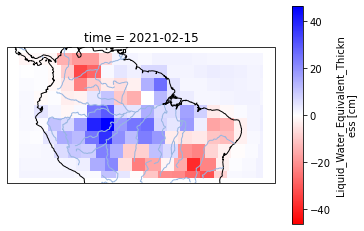

In [25]:
lat_bnds, lon_bnds = [-18, 10], [275, 330] #degrees east for longitude
ds_GRACE_subset = ds_GRACE.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_GRACE_subset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ds_GRACE_subset.lwe_thickness[193,:,:].plot(cmap = 'bwr_r') #106: July 2011
plt.show()

### On-premise data via OPeNDAP: River heights

In [27]:
ds_MEaSUREs = xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc')
ds_MEaSUREs

<xarray.Dataset>
Dimensions:   (X: 3311, Y: 3311, charlength: 26, distance: 3311, time: 9469)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ... 2019-04...
Dimensions without coordinates: X, Y, charlength, distance
Data variables:
    lon       (X) float64 ...
    lat       (Y) float64 ...
    FD        (distance) float64 ...
    height    (distance, time) float64 ...
    sat       (charlength) |S64 ...
    storage   (distance, time) float64 ...
    LakeFlag  (distance) float64 ...
    IceFlag   (time) float64 ...
Attributes: (12/40)
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Directory (GCMD)
    ...                            ...
    geospatial_lat_max:            -0.6550700975069503
    geospatial_lat_units:          degree_north
    geospatial_vertical_max:       92.7681246287056
    geospatial_vertical_min:       -3.563409518163376
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up

### SMAP
#### https://podaac.jpl.nasa.gov/dataset/SMAP_JPL_L3_SSS_CAP_MONTHLY_V5